In [1]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
import pandas as pd

from IPython.display import HTML

%matplotlib inline
HTML( '<style>.dataframe td { text-align: center; }</style>' );

In [2]:
# Setting evaluation date
calc_date = ql.Date(26,2,2018)
ql.Settings.instance().setEvaluationDate(calc_date)

# IR curve
flat_ir_rate = 0.02

# CDS market
recovery_rate = 0.40
cds_market = [ (0.5, 0.005), (1, 0.01), (2, 0.015), (3, 0.0175), (4, 0.02), (5, 0.035) ]

In [3]:
def build_ir_curve( flat_rate ):
    yts = ql.FlatForward( calc_date, flat_rate, ql.Actual365Fixed())
    yts.enableExtrapolation()
    libor_curve = ql.RelinkableYieldTermStructureHandle( yts )
    libor3M_index = ql.USDLibor(ql.Period( "3m" ), libor_curve )
    
    return libor3M_index, libor_curve

def build_cds_curve( cds_market ):
    cdss = [ ql.SpreadCdsHelper( ql.QuoteHandle( ql.SimpleQuote( s ) ),
                                ql.Period( int( t * 12 ), ql.Months ),
                                0,  # Settlement Days
                                ql.UnitedStates(),
                                ql.Quarterly,
                                ql.Following,
                                ql.DateGeneration.TwentiethIMM,
                                ql.Actual365Fixed(),
                                recovery_rate,
                                libor_curve ) for t,s in cds_market ]
    hazard_curve = ql.PiecewiseFlatHazardRate( calc_date, cdss, ql.Actual365Fixed() )
    hazard_curve.enableExtrapolation()
    
    return hazard_curve

In [4]:
# swap is 6M ACT/360 vs 3mLIBOR
def create_swap( tenor, index_curve, discount_curve, swap_rate, spread=0.0 ):
    calendar = ql.UnitedStates()
    settle_date = calendar.advance( calc_date, 2, ql.Days )
    maturity_date = calendar.advance( settle_date, tenor, ql.Years )

    fixed_leg_tenor = ql.Period(6, ql.Months)
    fixed_schedule = ql.Schedule(settle_date, maturity_date, 
                                 fixed_leg_tenor, calendar,
                                 ql.ModifiedFollowing, ql.ModifiedFollowing,
                                 ql.DateGeneration.Forward, False)

    float_leg_tenor = ql.Period(3, ql.Months)
    float_schedule = ql.Schedule( settle_date, maturity_date, 
                                  float_leg_tenor, calendar,
                                  ql.ModifiedFollowing, ql.ModifiedFollowing,
                                  ql.DateGeneration.Forward, False )
    
    ir_swap = ql.VanillaSwap(ql.VanillaSwap.Payer, 1.0, fixed_schedule, 
                swap_rate, ql.Actual360(), float_schedule,
                index_curve, spread, ql.Actual360() )
    
    return ir_swap, [index_curve.fixingDate(x) for x in float_schedule][:-1]

def price_swap( ir_swap, discount_curve ):
    swap_engine = ql.DiscountingSwapEngine( discount_curve )
    ir_swap.setPricingEngine( swap_engine )

    return ir_swap.fairRate()


In [5]:
libor3M_index, libor_curve = build_ir_curve( flat_ir_rate )

swap_rates = [ (i, price_swap( create_swap( i, libor3M_index, libor_curve, 0.0 )[0], libor_curve ) ) for i in range( 1, 6 ) ]
df_swaps = pd.DataFrame( data=swap_rates, columns=[ 'Swap_tenor', 'Fair_Spread' ] )
HTML( df_swaps.to_html( index=False ) )

Swap_tenor,Fair_Spread
1,0.019825
2,0.019825
3,0.019825
4,0.019825
5,0.019825


CDS pricing
===========

Show hazard rates
-----------------

In [6]:
hazard_curve = build_cds_curve( cds_market )

df_cds = pd.DataFrame( data=cds_market, columns=[ 'Tenor', 'CDS_Spread' ] )
df_cds[ 'Hazard_Rate' ] = [ n[1] for n in hazard_curve.nodes() ][ 1: ]
HTML( df_cds.to_html( index=False ) )

Tenor,CDS_Spread,Hazard_Rate
0.5,0.0050,0.008314
1.0,0.0100,0.026273
2.0,0.0150,0.034168
3.0,0.0175,0.038396
4.0,0.0200,0.047638
5.0,0.0350,0.185557


CVA Calculations
----

In [7]:
def calc_cva( calc_date, hazard_curve, discount_curve, index_curve, recovery_rate, ir_vol=0.0075, swap_term=5, swap_rate=0.0, notional=10000, N=2000, seed=1 ):

    ql.Settings.instance().setEvaluationDate(calc_date)
    
    # IR vol
    volas = [ql.QuoteHandle(ql.SimpleQuote(ir_vol)), ql.QuoteHandle(ql.SimpleQuote(ir_vol))]
    meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.02))]
    model = ql.Gsr( discount_curve, [calc_date+100], volas, meanRev, 16.)    
    
    # set up swap portfolio
    portfolio = [ create_swap( swap_term, index_curve, discount_curve, swap_rate ) ]
    
    # Setup pricing engine and calculate the npv
    #hyts = ql.RelinkableYieldTermStructureHandle( discount_curve )
    engine = ql.DiscountingSwapEngine(discount_curve)
    for deal, fixingDates in portfolio:
        deal.setPricingEngine(engine)
        deal.NPV()

    process = model.stateProcess()
    
    # Define evaluation grid
    date_grid = [ calc_date + ql.Period(i,ql.Months) for i in range(0,12*6) ]
    for deal in portfolio:
        date_grid += deal[1]

    date_grid = np.unique(np.sort(date_grid))
    time_grid = np.vectorize(lambda x: ql.ActualActual().yearFraction(calc_date, x))(date_grid)
    dt = time_grid[1:] - time_grid[:-1]
    
    # Calculation of the default probs
    defaultProb_vec = np.vectorize( hazard_curve.defaultProbability )
    dPD = defaultProb_vec(time_grid[:-1], time_grid[1:])
    
    # Random number generator
    urng = ql.MersenneTwisterUniformRng( seed )
    usrg = ql.MersenneTwisterUniformRsg( len( time_grid )-1,urng)
    generator = ql.InvCumulativeMersenneTwisterGaussianRsg( usrg )
    
    x = np.zeros((N, len(time_grid)))
    y = np.zeros((N, len(time_grid)))
    pillars = np.array([0.0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    zero_bonds = np.zeros((N, len(time_grid), 12))

    for j in range(12):
        zero_bonds[:, 0, j] = model.zerobond( pillars[j], 0, 0 )
        
    for n in range(0,N):
        dWs = generator.nextSequence().value()
        for i in range(1, len(time_grid)):
            t0 = time_grid[i-1]
            t1 = time_grid[i]
            
            x[n,i] = process.expectation(t0, x[n,i-1], dt[i-1]) + dWs[i-1] * process.stdDeviation(t0, x[n,i-1], dt[i-1] )
            y[n,i] = (x[n,i] - process.expectation(0,0,t1)) / process.stdDeviation(0,0,t1)
                        
            for j in range(12):
                zero_bonds[n, i, j] = model.zerobond( t1 + pillars[j], t1, y[n, i] )

    discount_factors = np.vectorize(discount_curve.discount)(time_grid)
    
    npv_cube = np.zeros((N,len(date_grid), len(portfolio)))
    for p in range(0,N):
        for t in range(0, len(date_grid)):
            date = date_grid[t]
            ql.Settings.instance().setEvaluationDate(date)
            ycDates = [date, 
                       date + ql.Period(6, ql.Months)] 
            ycDates += [date + ql.Period(i,ql.Years) for i in range(1,11)]
            yc = ql.DiscountCurve(ycDates, 
                                  zero_bonds[p, t, :], 
                                  ql.Actual365Fixed())
            yc.enableExtrapolation()
            discount_curve.linkTo(yc)
            if index_curve.isValidFixingDate(date):
                fixing = index_curve.fixing(date)
                index_curve.addFixing(date, fixing)
            for i in range(len(portfolio)):
                npv_cube[p, t, i] = portfolio[i][0].NPV()
        ql.IndexManager.instance().clearHistories()
        
    # revert the date
    ql.Settings.instance().setEvaluationDate(calc_date)
    #discount_curve.linkTo(yts)
    
    # Calculate the discounted npvs
    discounted_cube = np.zeros(npv_cube.shape)
    for i in range(npv_cube.shape[2]):
        discounted_cube[:,:,i] = npv_cube[:,:,i] * discount_factors
    
    # Calculate the portfolio npv by netting all NPV
    portfolio_npv = np.sum(npv_cube,axis=2)
    discounted_npv = np.sum(discounted_cube, axis=2)
    
    # calculate expected exposure
    dE = discounted_npv.copy()
    dE[dE<0] = 0
    dEE = np.sum(dE, axis=0)/N
    dEEstd = np.std( dE / N, axis=0 )
    
    # Calculation of the CVA
    CVA = (1-recovery_rate) * np.sum(dEE[1:] * dPD)
    return CVA, dEE, dEEstd, dPD

Calculate CVA charges and andjusted swap rates
---

In [8]:
def cva_helper( st, sr ):
    ql.Settings.instance().setEvaluationDate(calc_date)
    libor3M_index, libor_curve = build_ir_curve( flat_ir_rate )
    hazard_curve = build_cds_curve( cds_market )

    cva = calc_cva(calc_date, hazard_curve, libor_curve, libor3M_index, recovery_rate, swap_term=t, swap_rate=sr )[0]
    return cva
    
swap_cvas = [ (t, cva_helper( t, sr )) for t, sr in swap_rates ]

In [9]:
df_swap_cvas = pd.DataFrame( data=swap_cvas, columns=[ 'Swap_Tenor', 'CVA' ] )
HTML( df_swap_cvas.to_html( index=False ) )

Swap_Tenor,CVA
1,0.000004
2,0.000041
3,0.000132
4,0.000322
5,0.000717


In [10]:
def swap_helper( t, ic, dc, sr, sprd ):
    ir_swap, _ = create_swap( t, ic, dc, sr, sprd )
    asr = price_swap( ir_swap, dc )
    return asr

libor3M_index, libor_curve = build_ir_curve( flat_ir_rate )
hazard_curve = build_cds_curve( cds_market )
adjusted_swap_rates = [ swap_helper( t, libor3M_index, libor_curve, swap_rates[i][1], -swap_cvas[i][1] ) for i in range( len( swap_rates)) ]

In [11]:
df_swap_cvas[ 'ATM_Swap' ] = [ x[1] for x in swap_rates ]
df_swap_cvas[ 'Adjusted_Swap_Rate' ] = adjusted_swap_rates
HTML( df_swap_cvas.to_html( index=False ) )

Swap_Tenor,CVA,ATM_Swap,Adjusted_Swap_Rate
1,0.000004,0.019825,0.019821
2,0.000041,0.019825,0.019784
3,0.000132,0.019825,0.019693
4,0.000322,0.019825,0.019502
5,0.000717,0.019825,0.019107


## Calculate and graph Expected Exposure
### For 5y swap struck at 1.9825%


In [12]:
res = calc_cva(calc_date, hazard_curve, libor_curve, libor3M_index, recovery_rate, swap_term=5, swap_rate=0.019825 )

Calculated cva: 7.167 [bps]
Mean(EE): 52.467 [bps], std(EE): 0.045 [bps]


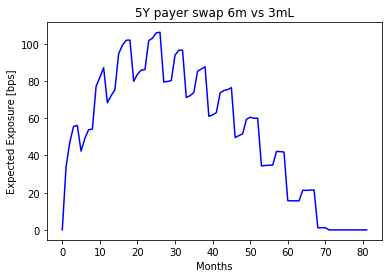

In [13]:
cva, ee, eestd, dpd = res

print( 'Calculated cva: {0:.3f} [bps]'.format( cva * 10000.0 ) )
print( 'Mean(EE): {0:.3f} [bps], std(EE): {1:.3f} [bps]'.format( ee.mean() * 10000.0, eestd.mean() * 10000.0 ) )
plt.plot( np.arange( ee.shape[0] ), ee * 10000.0, 'b' )
plt.ylabel( 'Expected Exposure [bps]' ); plt.xlabel( 'Months' ); plt.title( '5Y payer swap 6m vs 3mL' );